# Algoritmos de clasificación - Análisis lineal discriminante

**Nombre alumno: Juan Pablo Ramírez**

Profesor: Heriberto Briceño - Gonzalo Seguel.

Generación: **G-16**

### Solución Desafío - Análisis lineal discriminante

* Para poder realizar este desafío debes haber revisado la lectura y videos correspondiente a la unidad.
* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv).
* Una vez terminado el desafío, comprime la carpeta y sube el .zip a la sección correspondiente.

### Descripción
Trabajaremos con una base de datos sobre clientes morosos de un banco. Dentro de ésta se registran las siguientes observaciones:
* default : Variable Binaria. Registra si el cliente entró en morosidad o no.
* income : Ingreso promedio declarado por el cliente.
* balance : total del sando en la cuenta de crédito.
* student : Variable binaria. Registra si el cliente es estudiante o no.

### Ejercicio 1: Preparación de ambiente de trabajo

* Importe los módulos básicos para el análisis de datos.
* Importe las clases LabelEncoder , StandardScaler y LabelBinarizer de preprocessing
* Importe las funciones train_test_split y cross_val_score de model_selection
* Importe la función classification_report de metrics
* Importe las clases LinearDiscriminantAnalysis y QuadraticDiscriminantAnalysis .
* Agregue la base de datos en el ambiente de trabajo.
* Inspeccione la distribución de cada atributo.

In [1]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import missingno as msno
import glob
import os

# Métodos asociados
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Especificaciones
warnings.filterwarnings(action= 'ignore')
plt.style.use('seaborn-whitegrid')

# Funciones propias
from d4_funciones import *

In [2]:
df = pd.read_csv('default_credit.csv')
df_trabajo = df.drop('index', axis=1)

In [3]:
df_trabajo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
default    10000 non-null object
student    10000 non-null object
balance    10000 non-null float64
income     10000 non-null float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


In [4]:
df_trabajo.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


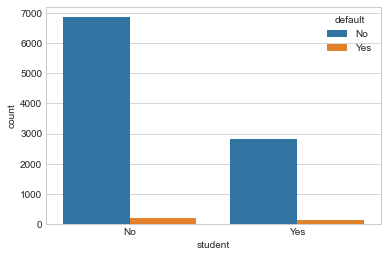

In [5]:
sns.countplot(df_trabajo['student'], hue=df_trabajo['default'])

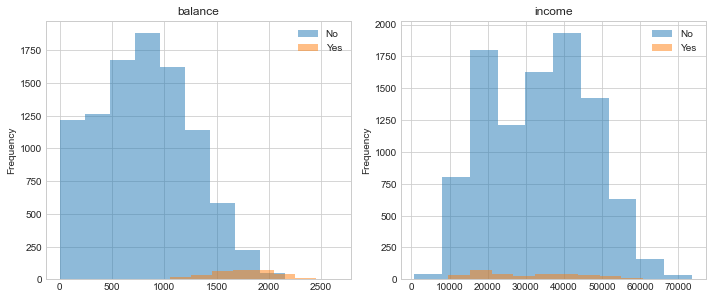

In [6]:
plt.figure(figsize=(10,8))
for n, i in enumerate(df_trabajo.drop(columns= ['default', 'student']).columns):
    plt.subplot(2, 2, n+1)
    df.groupby('default')[i].plot(kind='hist', alpha=.5)
    plt.title(i)
    plt.legend()
    plt.tight_layout()

### Ejercicio 2: Modelo base
* Recuerde que los modelos de sklearn no soportan datos que no sean numéricos. Transforme los atributos pertinentes con LabelEncoder.
* Genere muestras de validación y entrenamiento, reservando un 33% de los datos como validación.
* Genere un modelo con LinearDiscriminantAnalysis sin modificar los hiperparámetros.
Genere métricas de evaluación utilizando classification_report .
Comente sobre cuál es el desempeño del modelo en cada clase, así como en general.

In [7]:
df_trabajo['default'] = LabelEncoder().fit_transform(df_trabajo['default'])
df_trabajo['student'] = LabelEncoder().fit_transform(df_trabajo['student'])

In [8]:
y = df_trabajo['default']
X= df_trabajo.loc[:,['student', 'balance', 'income']]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state= 20000)

In [10]:
lda_model = LinearDiscriminantAnalysis().fit(X_train, y_train)

In [11]:
lda_model.priors_.round(2)

array([0.97, 0.03])

In [12]:
lda_class_pred = lda_model.predict(X_test)

In [13]:
tar = ['No', 'Yes']
targets = np.array(tar)
targets

array(['No', 'Yes'], dtype='<U3')

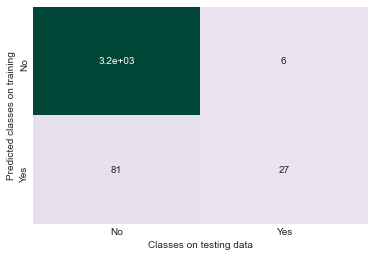

In [14]:
plot_confusion_matrix(y_test, lda_class_pred, targets)

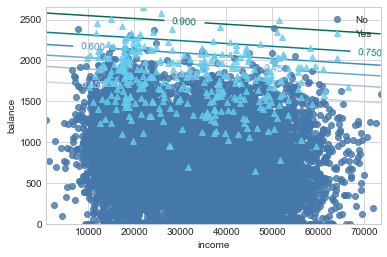

In [15]:
probability_contours(LinearDiscriminantAnalysis(), X, y, 'income', 'balance', targets)

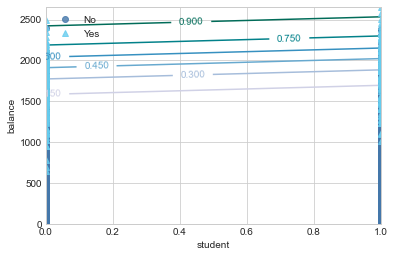

In [16]:
probability_contours(LinearDiscriminantAnalysis(), X, y, 'student', 'balance', targets)

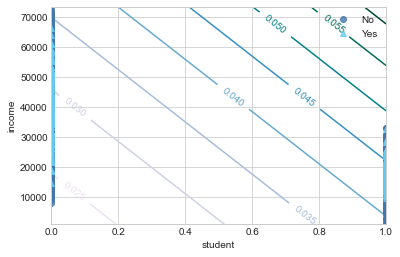

In [17]:
probability_contours(LinearDiscriminantAnalysis(), X, y, 'student', 'income', targets)

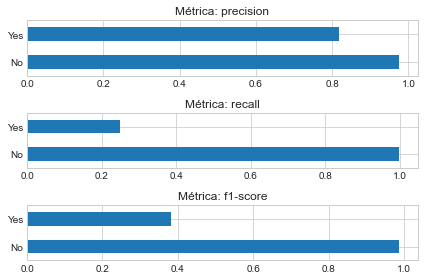

In [18]:
plot_class_report(y_test, lda_class_pred, targets)

* Comente sobre cuál es el desempeño del modelo en cada clase, así como en general.

En general, el modelo es capaz de detectar con precisiones, recall y F1-score sobre el 95% la presencia de personas no morosas. Sin embargo, si bien la precisión es cercana al 80% en las personas morosas, los recall y F1-score son menores al 40%. Esto se debe a que existe una alta cantidad de datos de personas no morosas en comparación con las que sí lo están. 

La baja cantidad de datos de personas morosas hace que la capacidad para que el modelo pueda discriminar entre las dos situaciones es muy baja, existiendo una sobreposición de los datos de morosidad y no morosidad. En parte, la alta precisión puede deberse a una fuerte concentración de los datos en una determinada zona, la que se encuentra sobrepuesta con datos de no morosos.

Se aprecia un alto sesgo de la información.

### Ejercicio 3: Refactorización 1 - información a priori
* Dado que trabajamos con modelos generativos, podemos incluír información exógena. Para este caso agregaremos dos distribuciones:
    * Asumamos que hay un 50/50 de morosos y no morosos.
    * Asumamos que hay un 60/40 de morosos y no morosos.
* Por cada modelo, reporte las métricas de clasificación.

In [19]:
compare_priors(X_train, X_test, y_train, y_test, [.5,.5])

A priori: [0.5, 0.5]
Accuracy: 0.704
Recall: 0.343
Precision: 0.039
F1: 0.07
AUC: 0.546



In [20]:
compare_priors(X_train, X_test, y_train, y_test, [.4,.6])

A priori: [0.4, 0.6]
Accuracy: 0.082
Recall: 1.0
Precision: 0.034
F1: 0.067
AUC: 0.546



#### Comentarios:
En general se aprecia que la aplicación de información a priori de las razones 50/50 y 60/40 no mejoran los aspectos indicados con anterioridad, reduciendo la precisión, el recall y el F1-score en todos los casos

### Ejercicio 4: Refactorización 2 - oversampling
**Digresión: Synthetic Over(Under)Sampling**
* Por lo general podemos intentar aliviar el problema del desbalance de clases mediante la ponderación dentro del algoritmo. Otra alternativa es el muestreo con reemplazo dentro de los conjuntos de entrenamiento. Estos métodos clásicos se conocen como Oversampling cuando repetimos registros aleatorios de la clase minoritaria, y Undersampling cuando eliminamos aleatoriamente registros de la clase mayoritaria.
* Un contratiempo de estos métodos clásicos es que pueden replicar información sesgada que afecte el desempeño de generalización del modelo. Si los datos son malos, estaremos replicando estas fallas. Otra solución es generar ejemplos de entrenamiento sintéticos mediante el entrenamiento de ejemplos de la clase minoritaria. A grandes rasgos la solución funciona de la siguiente forma: En función a un subconjunto de datos correspondientes a la case minoritaria, entrenamos algún modelo no supervisado o generativo como Naive Bayes, KMeans o KNearestNeighbors para generar representaciones sintéticas de los datos en el espacio de atributos de la clase específica mediante $\mathbf{x}{\textsf{nuevo-ejemplo}} = \mathbf{x}{i} + \lambda (\mathbf{x}{zi} - \mathbf{x}{i})$ donde $\mathbf{x}_{zi}$ es un ejemplo de entrenamiento de la clase minoritaria y $\lambda$ es un parámetro de interpolación aleatorio $\lambda \sim \textsf{Uniforme}(0, 1)$.

* Uno de los problemas más graves de esta base de datos, es el fuerte desbalance entre clases. Ahora generaremos observaciones sintéticas mediante SMOTE (Synthetic Minority Oversampling Technique). Para ello, debemos agregar el paquete a nuestro ambiente virtual. En nuestro terminal agregamos conda install -c conda-forge imbalanced-learn . Incorpore SMOTE en el ambiente de trabajo con la siguiente sintáxis from imblearn.over_sampling import SMOTE .
* Para implementar oversampling, debemos generar nuevos objetos que representan nuestra muestra de entrenamiento incrementada artificialmente. Para ello implemente la siguiente sintáxis:

```python
from imblearn.over_sampling import SMOTE
# Instanciamos la clase
oversampler = SMOTE(random_state=11238, ratio='minority')
# generamos el eversampling de la matriz de entrenamiento y
X_train_oversamp, y_train_oversamp = oversampler.fit_sample(X_train, y_train)
```
* Vuelva a entrenar el modelo con los datos aumentados de forma artificial y comente sobre su desempeño.

In [21]:
oversampler = SMOTE(random_state=20000, sampling_strategy='minority')

In [22]:
X_train_oversamp, y_train_oversamp = oversampler.fit_sample(X_train, y_train)

In [23]:
lda_model_smote = LinearDiscriminantAnalysis().fit(X_train_oversamp, y_train_oversamp)

In [24]:
lda_class_pred_smote = lda_model_smote.predict(X_test)

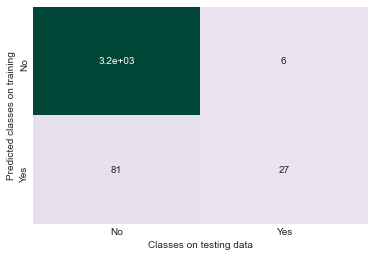

In [25]:
plot_confusion_matrix(y_test, lda_class_pred, targets)

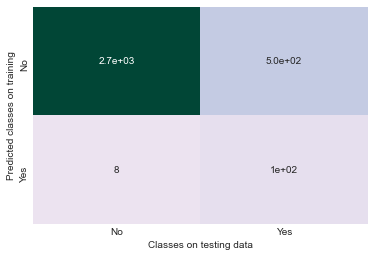

In [26]:
plot_confusion_matrix(y_test, lda_class_pred_smote, targets)

Métricas antes de la aplicación de SMOTE


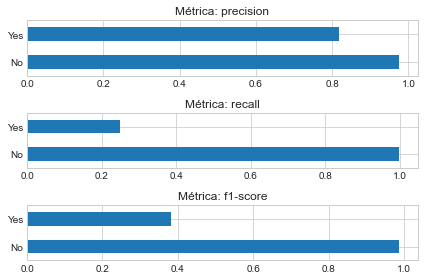

In [27]:
print('Métricas antes de la aplicación de SMOTE')
plot_class_report(y_test, lda_class_pred, targets)

Métricas después de la aplicación de SMOTE


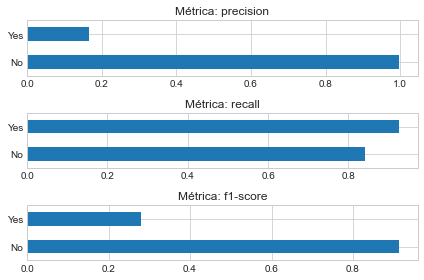

In [28]:
print('Métricas después de la aplicación de SMOTE')
plot_class_report(y_test, lda_class_pred_smote, targets)

#### Comentarios:
La aplicación de SMOTE aumentó el poder explicativo del modelo y disminuyó el sesgo en los casos en los que sí existía morosidad, reduciendo su precisión. Se aprecia una importante mejora en el recall, aumentando sobre el 95%; aunque existe una reducción del F1-score.

### Ejercicio 5: Refactorización 3 - QDA
* Por último, implemente un modelo QuadraticDiscriminantAnalysis con los datos aumentados artificialmente. Genere las métricas de desempeño.
* Comente a grandes rasgos sobre el mejor modelo en su capacidad predictiva.

In [30]:
qda_model_smote = QuadraticDiscriminantAnalysis().fit(X_train_oversamp, y_train_oversamp)
qda_predict_smote = qda_model_smote.predict(X_test)

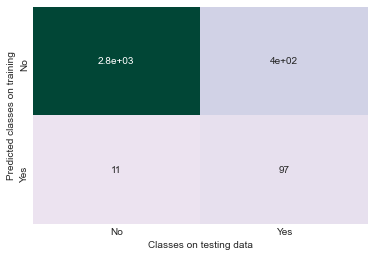

In [31]:
plot_confusion_matrix(y_test, qda_predict_smote, targets)

Métricas después de la aplicación de SMOTE


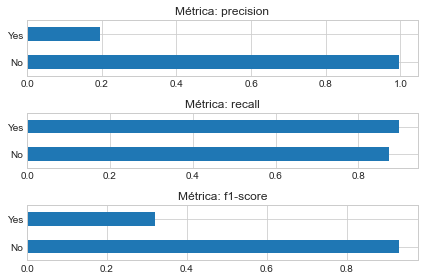

In [32]:
print('Métricas después de la aplicación de SMOTE')
plot_class_report(y_test, qda_predict_smote, targets)

#### Comentarios:
La aplicación de SMOTE en un modelo QDA, aumentó aún más el poder explicativo del modelo y disminuyó el sesgo en los casos en los que sí existía morosidad. Se aprecia un aumento significativo de la precisión de la detección de casos morosos, aunque se evidencia significativa caida en el recall. Se aprecia una importante mejora en el F1-score, aumentando sobre el sobre el 40%.

Este modelo reduce los sesgos y mejora 2 de los tres parámetros estudiados.